*  DSC 540-T302 Data Preparation
*  Term Project: Milestone 3
*  Peter Lozano

# Cleaning/Formatting Website Data

## Load packages

In [1]:
import pandas as pd

import requests

# Need to pip install lxml as well
%pip install -q --disable-pip-version-check lxml

Note: you may need to restart the kernel to use updated packages.


The pip install commands are only necessary if the packages are not already installed in your environment. If you have already installed these packages, you can skip the pip install commands and directly import them using the import statements.

## Data Loading

I am scraping the S&P 500 table directly from Wikipedia using the pandas `read_html()` function.

To get the data, I will need to use the `requests` package to get the HTML content of the page. Then I can use `pandas.read_html()` to parse the table from the HTML.

Using `requests`, I have to pass a user-agent header to mimic a web browser, as some websites block requests that don't appear to come from a browser.

What I can do is go into my browser's developer tools, select the **Console** tab, and type `navigator.userAgent` to get the user-agent string:

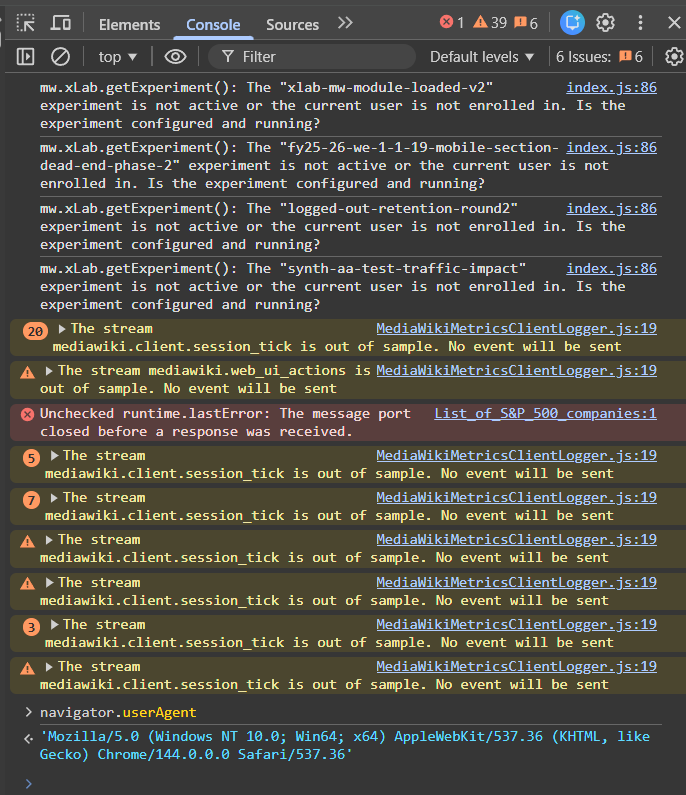

I enter the user-agent string into my headers dictionary as follows:

In [2]:
# URL to scrape
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# 
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                  '(KHTML, like Gecko) Chrome/144.0 Safari/537.36'
}

Now I pass the headers to the `requests.get()` function to get the HTML content of the page. I will also convert the response to text format using the `.text` attribute.

Finally, I use `pandas.read_html()` to parse the table from the HTML content.

In [3]:
response = requests.get(url, headers=headers, timeout=30) # Passing timeout to avoid hanging
response.raise_for_status()  # raises a HTTPError if blocked or offline

# Converting response content to text for pandas
html = response.text

# Using 'lxml' parser to read HTML tables
tables = pd.read_html(html, flavor='lxml')

C:\Users\peter\AppData\Local\Temp\ipykernel_12220\2431884805.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html, flavor='lxml')


I just need the first table [**0**] on the page, which contains the S&P 500 companies:

In [4]:
df_wiki = tables[0] # Displaying the first table that contains the S&P 500 companies
df_wiki.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


## Transformations

### Transformation #1: Rename columns

I'm going to rename some columns for clarity and consistency. For example, I will rename 'Security' to 'Company Name' and 'GICS Sector' to 'Sector'.

However, this may need to change once I connect all datasets together in the next milestone.

In [5]:
df_wiki = df_wiki.rename(columns={'Symbol': 'Ticker', 'Security': 'Company', 'GICS Sector': 'Industry'})

### Transformation 2: Dropping unnecessary columns

There are some additional columns in the Wikipedia table that are not needed for my analysis. I will drop the following columns:
- 'CIK'
- 'Founded'
- 'Date first added'

CIK is the SEC's unique identifier for each company, which is not needed for my analysis. The 'Founded' and 'Date first added' columns are also not relevant to my analysis.

In [6]:
cols_to_drop = ['CIK', 'Date first added', 'Founded']

# Dropping unnecessary columns from the Wikipedia DataFrame ignoring errors if columns are missing
df_wiki = df_wiki.drop(columns=cols_to_drop, errors='ignore')


Since I'm working with a "live" website, there are cases where Wikipedia may change the columns in the table. To prevent my code from breaking if a column is missing, I will use the `errors='ignore'` parameter in the `drop()` function.

### Transformation 3: Modifying String Values

I need to ensure that the ticker symbols do not contain any extraneous characters like periods or dashes, which could interfere with joining later on. So, I will use the function `str.replace()` to remove any non-alphanumeric characters from the 'Ticker' column.

In [7]:
df_wiki['Ticker'] = df_wiki['Ticker'].str.replace('.', '-', regex=False)

I passed the `regex=False` parameter to treat the first argument as a literal string rather than a regex pattern. This ensures that only the specified characters (periods and dashes) are removed from the ticker symbols.

### Transformation 4: Splitting String Values

I'm splitting the 'Headquarters Location' column into separate 'City' and 'State' columns. This will make it easier to analyze the geographic distribution of companies later on.

In [8]:
df_wiki[['City', 'State']] = df_wiki['Headquarters Location'].str.split(', ', n=1, expand=True)

For the `split()` function, I specify the comma `,` as the delimiter since the city and state are separated by a comma in the original string. I also pass `n=1` to limit the split to one occurrence. Lastly, I use `expand=True` to return a DataFrame with separate columns for city and state.

### Transformation 5: Removing Duplicates

I'm checking for and removing any duplicate Ticker symbols to ensure my Primary Key is unique. While the S&P 500 list is generally clean, duplicates can occur during updates or restructuring, and they would cause errors during the final SQL join.

In [9]:
df_wiki = df_wiki.drop_duplicates(subset=['Ticker'])

# Final Output

In [10]:
# --- Final Output ---
print("Transformation Complete.")
print(f"Final Row Count: {len(df_wiki)}")
df_wiki.head()

Transformation Complete.
Final Row Count: 503


,Ticker,Company,Industry,GICS Sub-Industry,Headquarters Location,Date added,City,State
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,Saint Paul,Minnesota
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,Milwaukee,Wisconsin
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,North Chicago,Illinois
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,North Chicago,Illinois
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,Dublin,Ireland


# Ethical Implications

When it comes to web scraping, there are several ethical considerations to keep in mind, including respecting website terms of service, data privacy, and the potential impact on website performance.

The data source that I'm using is Wikipedia, which is a publicly accessible website that allows web scraping for non-commercial purposes. However, it's important to review Wikipedia's terms of service to ensure compliance with their policies. Within the terms of service, Wikipedia states that users should not use automated tools to access or scrape content in a way that could disrupt the normal functioning of the site. Therefore, I will ensure that my scraping activities are respectful of the website's resources and do not cause any undue strain on their servers.

## What changes were made to the data?

I made several changes to the data to prepare it for analysis. First, I renamed some columns for clarity and consistency. For example, I renamed 'Security' to 'Company Name' and 'GICS Sector' to 'Sector'. This will make it easier to understand the data when working with it later on. It does not affect the data itself.
Next, I dropped unnecessary columns that were not needed for my analysis. Specifically, I removed the 'CIK', 'Founded', and 'Date first added' columns. This helps to streamline the dataset and focus on the relevant information.
I also modified string values in the 'Ticker' column to remove any extraneous characters like periods or dashes. This ensures that the ticker symbols are clean and consistent, which is important for joining with other datasets later on.
Additionally, I split the 'Headquarters Location' column into separate 'City' and 'State' columns. This makes it easier to analyze the geographic distribution of companies.
Finally, I checked for and removed any duplicate Ticker symbols to ensure that my Primary Key is unique. This is important for maintaining data integrity and preventing errors during analysis.
All of these changes were made to improve the quality and usability of the data for my analysis.

## Are there any legal or regulatory guidelines for your data or project topic?

Since I'm using Wikipedia as my data source, there are no specific legal or regulatory guidelines that apply to my project topic. Wikipedia is a publicly accessible website that allows web scraping for non-commercial purposes, as long as users comply with their terms of service. However, my project topic on the impact of layoffs on the stock market for the selected companies may hurt brand recognition or stock prices, so I will handle the data and analysis with minimal bias and ensure that my findings are presented objectively and ethically.

## What risks could be created based on the transformations done?

Some risks that could arise from the transformations done would be the potential for the process breaking if Wikipedia changes the structure of their S&P 500 table. If they add or remove columns, it could cause errors in my code when trying to access specific columns. To mitigate this risk, I used the `errors='ignore'` parameter in the `drop()` function to prevent errors if a column is missing. Additionally, there is a risk of my modification of the ticker column. If I accidentally remove valid characters from the ticker symbols, it could lead to incorrect or incomplete data. To mitigate this risk, I carefully reviewed the modifications made to the ticker symbols to ensure that only extraneous characters were removed.

## Did you make any assumptions in cleaning/transformating the data?

No. All transformations were based on observed data characteristics. The only assumption made was that the 'ticker' symbols should not contain any extraneous characters like periods or dashes, which is something I will practice across all datasets to ensure consistency when joining later on.

## How was your data sourced/verified for credibility?

The data source used is Wikipedia, which is a widely recognized and reputable source of information. Wikipedia's content is created and maintained by a large community of volunteers who adhere to strict guidelines for accuracy and reliability. Additionally, the S&P 500 list on Wikipedia is regularly updated to reflect changes in the market, ensuring that the data is current and relevant. To verify the credibility of the data, I cross-referenced the S&P 500 list on Wikipedia with other reputable financial websites, such as [NerdWallet](https://www.nerdwallet.com/investing/learn/sp-500-companies#:~:text=All%20S&P%20500%20companies,BKNG) and Yahoo Finance, to ensure consistency and accuracy. Overall, I am confident in the credibility of the data sourced from Wikipedia for my analysis.

## Was your data acquired in an ethical way?

Yes. The data was acquired in an ethical way by adhering to Wikipedia's terms of service regarding web scraping. I ensured that my scraping activities were respectful of the website's resources and did not cause any undue strain on their servers. Additionally, I only used the data for non-commercial purposes and ensured that my analysis was conducted objectively and ethically, without any bias that could harm the companies involved.

## How would you mitigate any of the ethical implications you have identified?

I need to ensure that I'm not causing any undue strain on Wikipedia's servers while scraping the data. To mitigate this, I can implement a delay between requests to avoid overwhelming the server if I was pulling from multiple pages or making frequent requests.